In [1]:
PROJECT_DIR = "/media/david/T7/code/bmcp/bmcp-notes"

In [2]:
import os
import math
from pathlib import Path

import pandas as pd
import numpy as np
import scipy.stats as stats
from plotnine import *
import pymc3 as pm

+ 1.0 Create fake data
    + 1.1 Setup base distributions
    + 1.2 View fake data parameters - distributions & parameters
    + 1.3 Sample from fake data distributions to create base dataset
    + 1.4 Add noise
+ 2.0 Model
    + 2.1 Setup Model
    + 2.2 Distributions of Priors
    + 2.3 Model using just the priors
    + 2.3 Fit the data
    + 2.4 Sample from the posterior distributions
+ 3.0 Review the model output
    + 3.1 Lambda 1 - Parameter for initial distribution
    + 3.2 Lambda 2 - parameter for second, shifted distribution
    + 3.3 Change day - parameter for day when distribution shifts from lambda 1 to lambda 2
    + 3.4 Check model against data

# 1.0 Create Fake Data
+ Stable period of n days at lambda 1
+ Next is a change window between 0 and m days, where lambda shifts from lambda 1 to lambda 2
+ Lambda 2 is maintained until the total number of days is reached

In [3]:
np.random.seed(989)
# np.random.seed(999)
lambda_1 = np.random.choice(range(10, 18))
lambda_2 = np.random.choice(range(15, 25))
stable_period = 30
change_window = 10
change_day = np.random.choice(range(0, change_window))
total_days = 70

days_at_1 = stable_period + change_day
days_at_2 = total_days - (stable_period + change_day)

## 1.1 Setup Base Distributions

In [4]:
lambda_1_dist = pd.Series(stats.poisson.pmf(np.arange(40), lambda_1)).reset_index().assign(lambda_val=1).rename(columns={0: 'proba', 'index': 'k'})
lambda_2_dist = pd.Series(stats.poisson.pmf(np.arange(40), lambda_2)).reset_index().assign(lambda_val=2).rename(columns={0: 'proba', 'index': 'k'})
df_dists = pd.concat([lambda_1_dist, lambda_2_dist], axis=0).reset_index(drop=True)
df_dists.head()

,k,proba,lambda_val
0,0,0.000017,1
1,1,0.000184,1
2,2,0.001010,1
3,3,0.003705,1
4,4,0.010189,1


## 1.2 View fake data distributions & parameters

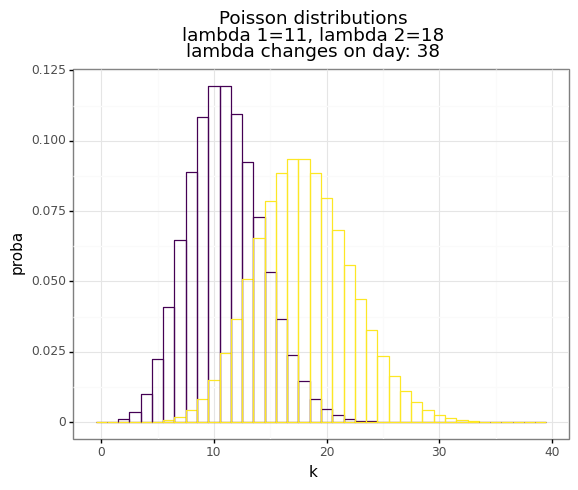

In [5]:
p = (ggplot(df_dists, aes(x='k', y='proba', colour='lambda_val')) +
     geom_col(position='dodge', alpha=0.5, width=1.0, fill="none") +
     theme_bw() +
     theme(legend_position="none") +
     labs(title=f"Poisson distributions\nlambda 1={lambda_1}, lambda 2={lambda_2}\nlambda changes on day: {days_at_1}")
    )
p.draw();

## 1.3 Sample from distribtions to create fake data

In [6]:
first = pd.DataFrame({'lambda': 1, 'n': range(0, days_at_1)})
second = pd.DataFrame({'lambda': 2, 'n': range(0, days_at_2)})
df_samples = pd.concat([first, second], axis=0).reset_index(drop=True)

In [7]:
samples_1 = stats.poisson.rvs(lambda_1, size=days_at_1)
samples_2 = stats.poisson.rvs(lambda_2, size=days_at_2)
df_samples['count'] = np.append(samples_1, samples_2)
df_samples = df_samples.reset_index().rename(columns={'index': 'day'})
df_samples.head()

,day,lambda,n,count
0,0,1,0,5
1,1,1,1,5
2,2,1,2,13
3,3,1,3,11
4,4,1,4,19


## 1.4 Add Noise
+ TODO

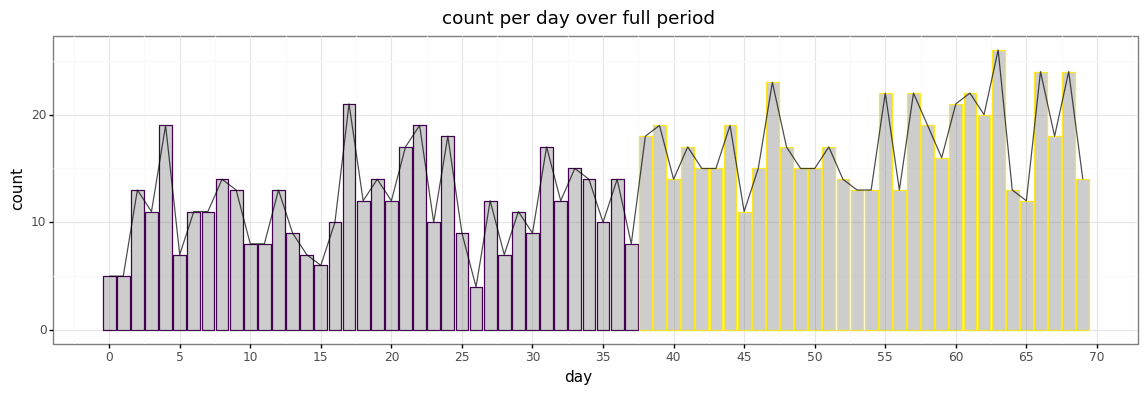

In [8]:
p = (ggplot(df_samples, aes(x='day', y='count', colour='lambda')) +
     geom_col(alpha=0.3) +
     geom_line(colour='black', alpha=0.7) +
     # geom_vline(xintercept=change_day, alpha=0.5) +
     scale_x_continuous(breaks=np.arange(0, total_days+1, 5)) +
     labs(title="count per day over full period") +
     theme_bw() +
     theme(legend_position="none") +
     theme(figure_size=(14, 4)))
p.draw();

# 2.0 Model

## 2.1 Setup Model

In [9]:
with pm.Model() as model:
    alpha = 1.0/df_samples['count'].mean() # The mean count per day across the full dataset
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=total_days)
    # We have setup an initial stable period, so lower could be adjusted to equal stable period, but leave as for simplicity
    

In [10]:
with model:
    idx = np.arange(total_days) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

## 2.2 Review Distributions of priors

In [11]:
alpha = 1.0 / df_samples['count'].mean()
print(alpha)

0.07063572149344097


In [12]:
mn = 0.000 ; mx = 1.5
x = np.linspace(mn, mx, 3001)
expon_df = pd.DataFrame({'z': x, 'pdf at z': stats.expon.pdf(x, scale=alpha)})
expon_df.head()

,z,pdf at z
0,0.0000,14.157143
1,0.0005,14.057284
2,0.0010,13.958130
3,0.0015,13.859675
4,0.0020,13.761915


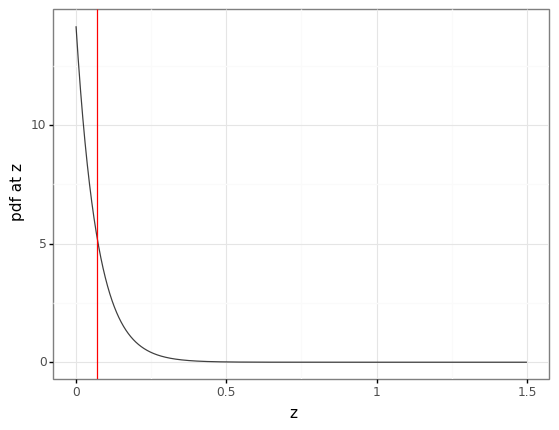

In [13]:
# Exponential pdf
p = (ggplot(expon_df, aes(x='z', y='pdf at z')) +
     geom_line(alpha=0.75) +
     geom_vline(aes(xintercept=alpha), color='red') +
     theme_bw()
    )
p.draw();

In [14]:
# tau = pm.DiscreteUniform("tau", lower=0, upper=total_days)
i_vals = range(0, total_days)
tau_df = pd.DataFrame({'i': i_vals, 'pmf at i': stats.randint.pmf(i_vals, 0, total_days)})
tau_df.head()

,i,pmf at i
0,0,0.014286
1,1,0.014286
2,2,0.014286
3,3,0.014286
4,4,0.014286


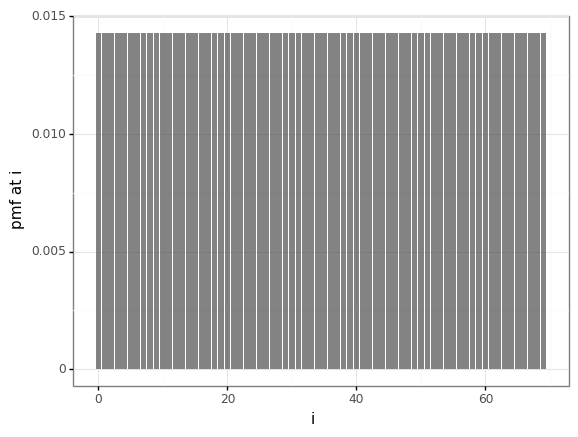

In [15]:
# Uniform pmf
p = (ggplot(tau_df, aes(x='i', y='pmf at i')) +
     geom_col(alpha=0.75) +
     theme_bw()
    )
p.draw();

## 2.3 Model using just the priors
TODO

In [16]:
model

## 2.4 Fit the Data

In [17]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=df_samples['count'].values)

In [18]:
# with model:
#     p = pm.sample_prior_predictive()
# p

## 2.5 Sample from the posterior distributions of the fitted data

In [19]:
# Sample from the posterior distributions of the fitted model
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 7 seconds.
The number of effective samples is smaller than 10% for some parameters.


# 3.0 Review the model output

In [20]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

In [21]:
lambda_1_samples

array([11.75113456, 11.65779414, 11.16653586, ..., 11.84530349,
       11.84530349, 11.84530349])

In [22]:
lambda_1_samples = pd.DataFrame(lambda_1_samples).rename(columns={0:'lambda_1_samples'}).reset_index()
lambda_2_samples = pd.DataFrame(lambda_2_samples).rename(columns={0:'lambda_2_samples'}).reset_index()
tau_samples = pd.DataFrame(tau_samples).rename(columns={0:'tau_samples'}).reset_index()
# lambda_1_samples.describe()

## 3.1 Lambda 1 Posterior Distribution

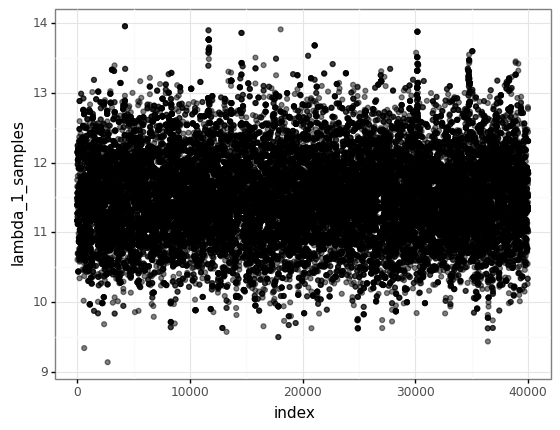

In [23]:
p = (ggplot(lambda_1_samples, aes(x='index', y='lambda_1_samples')) +
     geom_point(alpha=0.5) +
     theme_bw()
    )
p.draw();

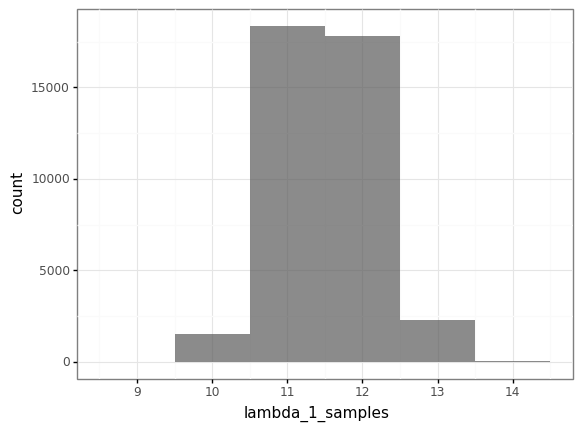

In [24]:
sample_size=1000
p = (ggplot(lambda_1_samples, aes('lambda_1_samples')) +
     geom_histogram(binwidth=1, alpha=0.7) +
     scale_x_continuous(breaks=np.arange(math.floor(lambda_1_samples['lambda_1_samples'].min()),
                                         math.floor(lambda_1_samples['lambda_1_samples'].max())+2, 1)) +
     theme_bw()
    )
p.draw();

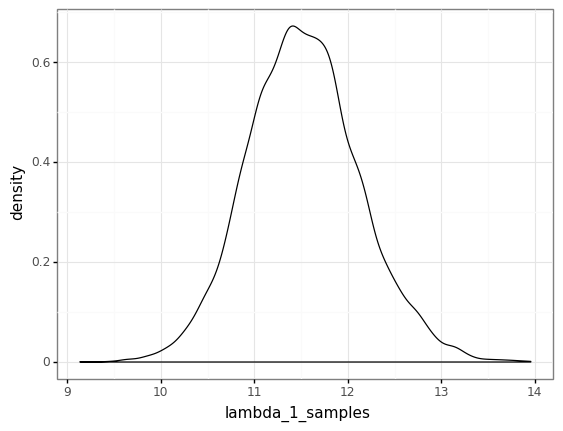

In [25]:
sample_size=10000
p = (ggplot(lambda_1_samples.sample(sample_size), aes('lambda_1_samples')) +
     geom_density(alpha=0.7) +
     theme_bw()
    )
p.draw();

## 3.2 Lambda 2 Posterior Distribution

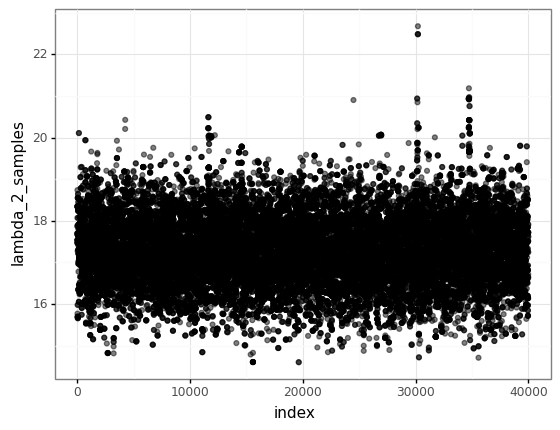

In [26]:
p = (ggplot(lambda_2_samples, aes(x='index', y='lambda_2_samples')) +
     geom_point(alpha=0.5) +
     theme_bw()
    )
p.draw();

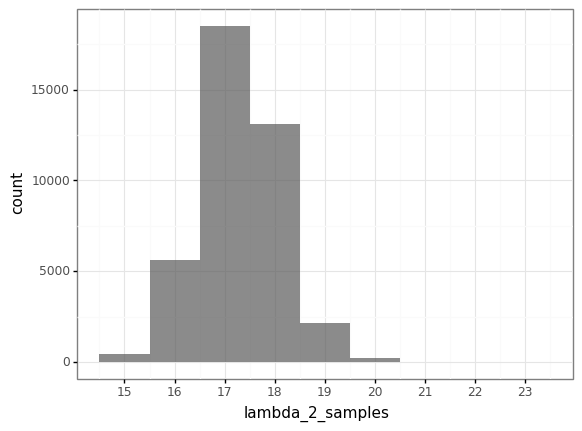

In [27]:
sample_size=1000
p = (ggplot(lambda_2_samples, aes('lambda_2_samples')) +
     geom_histogram(binwidth=1, alpha=0.7) +
     scale_x_continuous(breaks=np.arange(math.floor(lambda_2_samples['lambda_2_samples'].min()),
                                         math.floor(lambda_2_samples['lambda_2_samples'].max())+2, 1)) +
     theme_bw()
    )
p.draw();

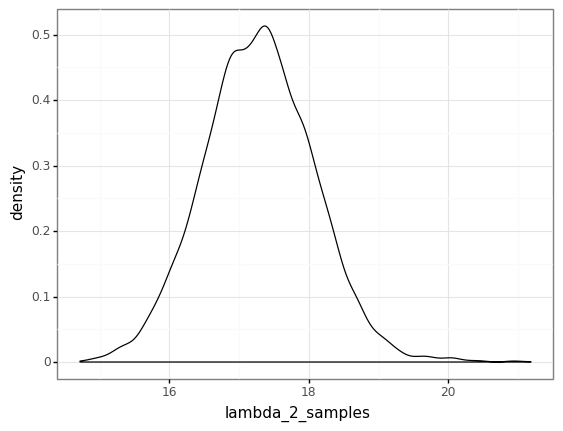

In [28]:
sample_size=10000
p = (ggplot(lambda_2_samples.sample(sample_size), aes('lambda_2_samples')) +
     geom_density(alpha=0.7) +
     theme_bw()
    )
p.draw();

## 3.3 Tau Posterior Distribution

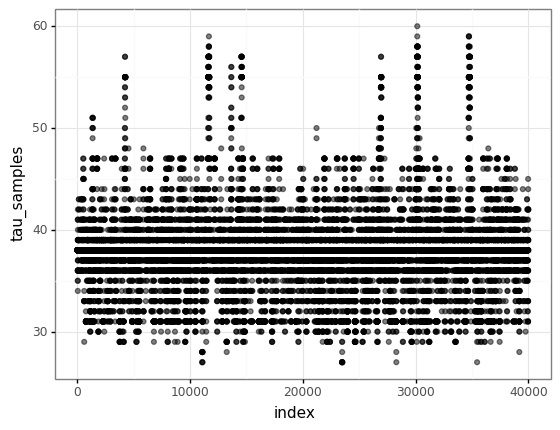

In [29]:
p = (ggplot(tau_samples, aes(x='index', y='tau_samples')) +
     geom_point(alpha=0.5) +
     theme_bw()
    )
p.draw();

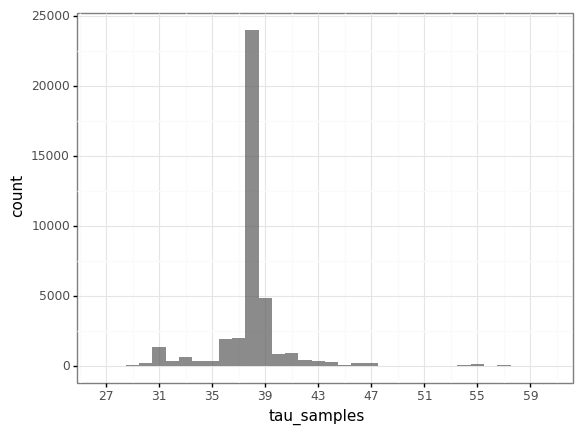

In [30]:
p = (ggplot(tau_samples, aes('tau_samples')) +
     geom_histogram(binwidth=1, alpha=0.7) +
     scale_x_continuous(breaks=np.arange(math.floor(tau_samples['tau_samples'].min()),
                                         math.floor(tau_samples['tau_samples'].max())+2, 4)) +
     theme_bw()
    )
p.draw();

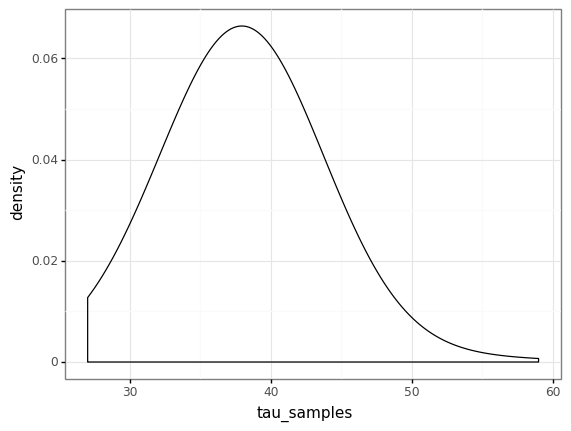

In [31]:
sample_size=10000
p = (ggplot(tau_samples.sample(sample_size), aes('tau_samples')) +
     geom_density(alpha=0.7) +
     theme_bw()
    )
p.draw();

## 3.4 Check the model against the data
TODO